# GP Regression 
The focus this week is on modelling the CO2 concentration at Mauna Loa using Gaussian Process Regression.

## Overview
- **Task 1**: Implement your own kernel and requirements for hyperparameter optimization.
- **Task 2**: Use `scikit-learn.gaussian_process` to build and fit a model to the provided CO$_2$ data and extrapolate.

**Note**: This notebook relies on the packages `numpy`, `matplotlib`, `scipy` and `scikit-learn`

In [8]:
# Necessary packages for first part
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import scipy.optimize

# %matplotlib notebook
%matplotlib inline

# Task 1
Below you will find the code for a class `SquareExponential(Kernel)` which is defined by the two hyperparameters $\ell$ and $\sigma$:

$$
K(x_1,x_2)= \sigma^2 \exp\left(-\frac{(x_1-x_2)^2}{2\ell^2}\right)
$$

**Tasks**:
1. Implement `SquareExponential.K` to return the expression above.
2. Implement `SquareExponential.dK_dl` to return the derivative w.r.t. $\ell$ and fill in your expression below.
3. Implement `SquareExponential.dK_dsigma` to return the derivative w.r.t. $\sigma$ and fill in your expression below.

Derivative w.r.t. $\ell$:


Derivative w.r.t. $\sigma$:

Hint: Try to "resuse" $K(x_1,x_2)$ in your expressions and implementations.

The cell below also contains a utility function `test_dK_dl` which compares your implemented derivative against a numerical approximation.

In [ ]:
from utils import Kernel, test_dK_dl
        
class SquareExponential(Kernel):
    
    def __init__(self,sigma=1,ell=1,**kwargs):
        super().__init__(**kwargs)
        self.params['sigma']=sigma
        self.params['ell']=ell
        

    def K(self,x1,x2):
        """Returns the kernel applied to the inputs x1 and x2. Expects inputs of shape: 
        x1: (N1,1)
        x2: (N2,1)
        returns: kernel matrix of shape (N1,N2)
        """
        ####################
        raise NotImplementedError
        ####################
        
    
    def dK_dl(self,X):
        """ 
        Expects input X of shape (N,1) and returns the (N,N) matrix
        with the derivative w.r.t. ell  applied elementwise to K(X,X) 
        """
        ####################
        raise NotImplementedError
        ####################
    
    def dK_dsigma(self,X):
        """ 
        Expects input X of shape (N,1) and returns the (N,N) matrix
        with the derivative w.r.t. sigma  applied elementwise to K(X,X) 
        """
        ####################
        raise NotImplementedError
        ####################
    

test_dK_dl(SquareExponential(),eps=1e-3,verbose=False)   

### Test kernel
If you have implemented the function for calculating $K(x_1,x_2)$ then you can run the code below and try it out.

We will model a latent function $f$ as:
$$
p(f)=\mathcal{GP}(0,K_{se})
$$

with uncorrelated gaussian noise with variance $\sigma_n^2$:

$$
p(Y\mid f, X)=\mathcal{N}(Y; f(X), \sigma_n^2 I) 
$$

For details on the calculations see the lecture slides.

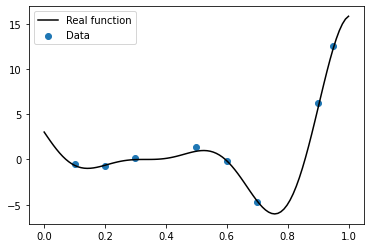

In [9]:
# Generate some data

def forrester(x):
    return (6*x - 2)**2*np.sin(12*x-4)

np.random.seed(42)
X=np.array([0.1,0.2,0.3,0.5,0.6,0.7,0.9,0.95]).reshape(-1,1)
Y=forrester(X)+0.3*np.random.randn(*X.shape) # add normal distributed noise with standard deviation 0.3

plt.figure()
x=np.linspace(0,1,100).reshape(-1,1)
plt.plot(x,forrester(x),'k',label='Real function')
plt.scatter(X,Y,alpha=1,marker='o',color='C0',label='Data')
plt.legend()
plt.show()

In [ ]:
####################
# Test out different hyperparameters (SE_sigma,SE_ell) below and see how the visual quality of
# the predictions change. 
# You can also try to maximize the marginal likelihood by hand.
####################
SE_sigma=None
SE_ell=None
####################


Kse=SquareExponential(sigma=SE_sigma,ell=SE_ell,noise=0.3)

# alpha = inv(K_y).dot(Y)
alpha,log_ml=Kse.condition_f_observation(X,Y)

print('Log marginal likelihood: {}'.format(log_ml))

# Make predictions at x
x=np.linspace(0,1,100).reshape(-1,1)

# Calculate covariance between test data x and training data X
KxX=Kse.K(x,X)

#Calculate mean
fx=KxX.dot(alpha)

#Calculate variance
v=np.linalg.solve(Kse.L,KxX.T).T
f_std=np.sqrt(np.diag(Kse.K(x,x) - v.dot(v.T)))


#plot data, mean and variance
plt.figure()
plt.plot(x,forrester(x),'k',label='Real function')
plt.plot(x,fx,'C1',label='f(x)')
plt.fill_between(x.ravel(),fx.ravel()-1.96*f_std,fx.ravel()+1.96*f_std,color='C1',alpha=0.3,label='95%')
plt.scatter(X,Y,alpha=1,marker='o',color='C0',label='Data')
plt.legend()
plt.show()

**Interlude**

Finding suitable hyperparameters can be tiresome but it can be automated if we have access to derivatives of the kernel w.r.t. hyperparameters.

We can find the the hyperparameters that maximize the log-marginal likelihood. 
The function that we want to maximize is:
$$
\log p(Y\mid X,\theta)= -\frac{1}{2}Y^\top K_Y^{-1} Y - \frac{1}{2}\log|K_Y| +C 
$$
Where in our case 
$$K_y= K_{SE}(X,X) +\sigma^2_n I$$
The derivative of the above expression w.r.t. to the kernel hyperparameters ($\theta$) is given by 

$$
\frac{\partial}{\partial \theta} \log p(Y\mid X,\theta)=\frac{1}{2}Y^\top K_y^{-1} \frac{\partial K}{\partial \theta} K_y^{-1}Y -\frac{1}{2}\operatorname{tr} \left(K_y^{-1}\frac{\partial K}{\partial \theta} \right) =\\
= \frac{1}{2}\left( (\alpha \alpha^\top - K_y^{-1})\frac{\partial K}{\partial \theta} \right).
$$

(See Ch. 5.4.1 in [GPML](http://www.gaussianprocess.org/gpml/chapters/RW.pdf) for details.)

### Optimize kernel
The cell below will optimize the parameters of your kernel if you have a correct implementation of `dK_dl` by *minimizing* the *negative* of the expression above

In [ ]:
SE_sigma=1e0
SE_ell=1e0
th=np.array([SE_sigma,SE_ell])

# noise scale is not being optimized
noise=0.3

def neg_log_ml(th,noise):
    Kse= SquareExponential(sigma=th[0],ell=th[1],noise=noise)
    alpha,log_ml=Kse.condition_f_observation(X,Y)
    derivatives=[]
    for K_der in [Kse.dK_dsigma,Kse.dK_dl]:
        dK_dthi = K_der(X)
        derivatives.append(0.5*np.sum(alpha.T.dot(dK_dthi.dot(alpha)))-0.5*np.trace(np.linalg.solve(Kse.L.T,np.linalg.solve(Kse.L,dK_dthi)))) 
    return -log_ml,-np.array(derivatives)


res=scipy.optimize.minimize(neg_log_ml,th,args=(noise),jac=True,options={'maxiter':25})
print(res.x)
print(f'Optimized values: \nSE_sigma={res.x[0]:.3f} \n  SE_ell={abs(res.x[1]):.3f}')

In [ ]:
####################
# Same cell as above but with optimized hyperparameters
####################
SE_sigma=res.x[0]
SE_ell=res.x[1]

Kse=SquareExponential(sigma=SE_sigma,ell=SE_ell,noise=0.3)

# alpha = inv(K_y).dot(Y)
alpha,log_ml=Kse.condition_f_observation(X,Y)

print('Log marginal likelihood: {}'.format(log_ml))

# Make predictions at x
x=np.linspace(0,1).reshape(-1,1)#X

# Calculate covariance between test data x and training data X
KxX=Kse.K(x,X)

#Calculate mean
fx=KxX.dot(alpha)

#Calculate variance
v=np.linalg.solve(Kse.L,KxX.T).T
f_std=np.sqrt(np.diag(Kse.K(x,x) - v.dot(v.T)))

#plot data, mean and variance
plt.figure()
plt.plot(x,forrester(x),'k',label='Real function')
plt.plot(x,fx,'C1',label='f(x)')
plt.fill_between(x.ravel(),fx.ravel()-1.96*f_std,fx.ravel()+1.96*f_std,color='C1',alpha=0.3,label='95%')
plt.scatter(X,Y,alpha=1,marker='o',color='C0',label='Data')
plt.legend()
plt.show()

## Concluding remarks 
You have now implemented a simple example of GP inference and seen what is required to do hyperparameter optimization. Any GP library you find will implement this functionality in one way or another.

# Task 2
We will now move on to modelling of the CO$_2$ data by using the functionality provided by `scikit-learn`. We start by reading the data from the provided textfile and plotting it.

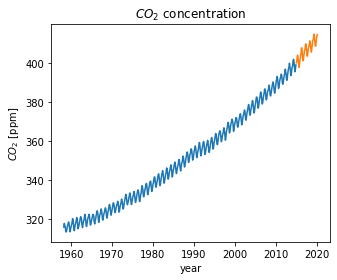

In [10]:
filename="co2_mm_mlo.txt"
data=np.genfromtxt(filename,comments='#',missing_values='-99.99',usecols=[2,3])
missing=data[:,-1]==-99.99
data=data[~missing]
Xfull=data[:,0:1]
Yfull=data[:,-1:]
data=[]
I=Xfull<2015

#Training data up until 2015
X=Xfull[I].reshape(-1,1)
Y=Yfull[I].reshape(-1,1)

# Test data 2015 and later
Xtest=Xfull[~I]
Ytest=Yfull[~I]


Xmean=np.mean(X)
Ymean=np.mean(Y)


X-=Xmean
Y-=Ymean

Xtest-=Xmean
Ytest-=Ymean


plt.figure(figsize=(5,4))
plt.plot(X+Xmean,Y+Ymean)
plt.plot(Xtest+Xmean,Ytest+Ymean)
plt.title(r'$CO_2$ concentration')
plt.xlabel('year')
plt.ylabel(r'$CO_2$ [ppm]')
plt.show()

There are several frameworks available for GP inference of which one of the most popular due to its simplicity is provided in `scikit-learn`. 
Other popular frameworks for python include: [GPy](https://gpy.readthedocs.io/en/deploy/), [GPFlow](https://www.gpflow.org/) and [GPytorch](https://gpytorch.readthedocs.io/en/latest/).

The cell below will load the available kernels and functionality.

In [ ]:
# Necessary packages for second part
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, RationalQuadratic,
                                              ExpSineSquared, DotProduct,Matern,
                                              ConstantKernel as C,WhiteKernel)

The available kernels are:
- RBF/Square Exponential/Gaussian/Exponentiated Quadratic
- Rational Quadratic
- Exponential Sine Squared
- Dot Product
- Constant
- White Noise Kernel
- Matern

## Information
**Check** the [**Kernel cookbook**](https://www.cs.toronto.edu/~duvenaud/cookbook/) for intuition on how to use and combine the different kernels. 
It will explain the first 4 kernels in the list and show examples of adding and multiplying kernels together.


## Additional
The **`Constant`** kernel corresponds to a multiplicative factor that can be used together with other kernels to learn the scale of the kernel. 
For example: the RBF kernel is implemented as $K_{RBF}(x,y)= \exp\left(-\frac{d(x,y)^2}{2\ell^2} \right)$. 
To get a kernel with variance/scale different from 1 we can use:
```python
    K1 = 2.8 * RBF(length_scale=3.0)
    #Is equivalent to
    K1 = ConstantKernel(constant_value=2.8) * RBF(length_scale=3.0)
```

The **`WhiteKernel`** corresponds to uncorrelated gaussian noise and has kernel $K_W(x,y)=\sigma^2 \delta_{xy}$ corresponding to a diagonal Gram matrix. It is the only kernel in the implementation with a built-in scaling/ConstanKernel.


The last kernel on the list is the **`Matern`** family ([definition](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function)). 
It is often seen as a more realistic alternative to the RBF since they have similar behaviour but it is not infinitely continuously differentiable. The parameter $\nu$ ("nu") controls the smoothness of the functions from these kernels as:
- $\nu=1/2$: no continuous derivative
- $\nu=3/2$: 1 continuous derivative
- $\nu=5/2$: 2 continuous derivatives



## Further tips
- It is possible to define bounds (2 limits or "fixed") for the hyperparameters when defining the kernel if you know that the hyperparameter should have a fixed value or limited to a smaller range.
- The optimization landscape of the hyperparameters has several local minima, therefore it is good to initialize hyperparameters closer to reasonable values. 
- Kernels are automatically combined into a more complex kernel by the addition and mutliplication operations:
```python
kernel = 2.0*RationalQuadratic(length_scale=2,alpha=3,length_scale_bounds=(1e0, 1e1),
    alpha_bounds="fixed")*RBF() + WhiteKernel()
```



# Task 2
It can take a while to fit a GP to the full data so you can use the cell below to get familiar with the framework and kernels by training on a small subset.

In [ ]:
# Small training set
Xsmall=np.copy(X[-120:])
Ysmall=np.copy(Y[-120:])

Xsmall-=np.mean(Xsmall)
Ysmall-=np.mean(Ysmall)

# Test points to evaluate
x=np.linspace(Xsmall[0]-2,Xsmall[-1]+2,200) 


####################
# Define your kernel
####################
kernel = None
####################

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1)


# Sample from prior at x
y_prior_mean, sigma_prior = gp.predict(x, return_std=True)
y_samples = gp.sample_y(x, 3)


# Plot prior samples
plt.figure()
plt.title('Prior')
plt.plot(x, y_prior_mean, 'b-', label='Prior mean')
plt.plot(x, y_samples)

plt.fill_between(x.ravel(),y_prior_mean - 1.96 * sigma_prior,y_prior_mean + 1.96 * sigma_prior,
         alpha=.3, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='upper left')


# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(Xsmall, Ysmall)


#Predict mean and standard deviation
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.title(f'Posterior [{gp.log_marginal_likelihood():.2f}]')
plt.plot(Xsmall, Ysmall, 'r.', markersize=5,alpha=0.7, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x.ravel(),y_pred.ravel() - 1.96 * sigma,y_pred.ravel() + 1.96 * sigma,
         alpha=.3, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='upper left')
plt.show()

print('Prior:     ',gp.kernel)
print('Posterior: ',gp.kernel_)
print('log marginal likelihood: {:.2f}'.format(gp.log_marginal_likelihood()))

# Task 2: Model the CO$_2$ data
You now have all the tools required for modelling the data. 

**Tasks**
1. Construct your kernel and fit your `GaussianProcessRegressor` in the cell below.
2. Write down the individual components of the kernel you decide to use below (replace the example) and provide a description of their purpose.
3. Plot the prediction and 95% confidence interval over the training data and 40 years into the future.




======================================

Example:
$$
K = K_1 + K_2
$$
- $K_1=DP$: long term rising trend
- $K_2=K_W$: additive white noise

======================================


Use the following abbreviations:
- RBF: RBF
- Rational Quadratic: RQ
- Exponential Sine Squared: ESS
- Dot Product: DP
- Constant
- White Noise Kernel: W
- Matern: M(nu)


In [ ]:
####################
# Define your kernel
####################
kernel = None
####################

# You can try with more restarts once you have settled on a good kernel
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1)

# Fit hyperparameters to training data X,Y
gp.fit(X, Y)

# Print information about prior and posterior parameters
print('log marginal likelihood: {:.2f}'.format(gp.log_marginal_likelihood()))
print()
print('Prior:\n',gp.kernel)
print()
print('Posterior:\n',gp.kernel_)

**Plot your prediction and 95% confidence interval**

In [ ]:
# Predict function value and uncertainty at x which covers
# the training data and 40 years in the future
x=np.linspace(X[0],X[-1]+40,2000)

Y_pred, sigma = gp.predict(x, return_std=True)

plt.figure()
plt.title(f'Prediction')
plt.plot(X+Xmean, Y+Ymean, 'r.', markersize=5,alpha=0.5, label='Observations')
plt.plot(Xtest+Xmean, Ytest+Ymean, 'C1.', markersize=5,alpha=0.5, label='Test')
plt.plot(x+Xmean, Y_pred + Ymean, 'b')
plt.fill_between(x.ravel() + Xmean, Y_pred.ravel() + Ymean - 1.96 * sigma, Y_pred.ravel() + Ymean + 1.96 * sigma,
         alpha=.3, fc='b', ec='None', label='95% confidence interval')


plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='upper left')

plt.show()